In [ ]:
#Remove this after finishing.
#import os
#os.chdir('./NewRuns_forGitHub')
#print(os.getcwd())

In [1]:
# import all required libraries
import sys, os
import numpy as np
import pandas as pd
import random
from random import shuffle, choice
import time
import os
import glob
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from random import shuffle, choice
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# define a function to build MLP for the trait data.    
def create_mlp(traitstrain, regularizer=None):
  model = Sequential()
  # first layer, remember to remove bias if you are intercalating with batch normalization. ReLu is the activation (nonlinear) function. We use a L1 regularizer #add more here and to the text.
  model.add(Dense(150, use_bias=False, input_dim=traitstrain.shape[1], activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  # batch normalization.
  model.add(BatchNormalization())
  # second layer.
  model.add(Dense(150, use_bias=False, activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  model.add(BatchNormalization())
  # third layer.
  model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  return model

# define a function to build a CNN for the SNP data. 
def create_cnn(xtest, regularizer=None):
  # obtain the input dimensions.
  inputShape = (xtest.shape[1], xtest.shape[2])
  inputs = Input(shape=inputShape)
  x = inputs
  # first convolutional layer, remember to remove bias if you are intercalating with batch normalization.
  x = Conv1D(250, kernel_size=3, activation='relu', use_bias=False, input_shape=(xtest.shape[1], xtest.shape[2]))(x)
  # batch normalization.
  x = BatchNormalization()(x)
  # second layer.
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  # third layer.
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  # pool the CNN outputs.
  x = MaxPooling1D(pool_size=3)(x)
  # flatten in a single vector.
  x = Flatten()(x)
  # this part is similar to the MLP, a fully connected neural network. We intercalated with dropout to reduce overfitting.
  x = Dense(125, activation='relu')(x)
  # dropout.
  x = Dropout(0.5)(x)
  # second layer of the fully connected neural network.
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  # third layer of the fully connected neural network. This one matches the number of nodes coming out of the MLP.
  x = Dense(50, kernel_regularizer=regularizer)(x)
  x = Activation("relu")(x)
  # Construct the CNN
  model = Model(inputs, x)
  # Return the CNN
  return model

# define a function to combine the outputs of the MLP and the CNN.
# this was obtained from: https://towardsdatascience.com/neural-networks-ensemble-33f33bea7df3
class LinearW(Layer):
    def __init__(self):
        super(LinearW, self).__init__()    
    def build(self, input_shape):
        self.W = self.add_weight(name='name',
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
    def call(self, inputs):
        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim
        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

In [2]:
## define variables that will be used to train all networks.
# size of the minibatches containing simulations are passed through the network in each epoch.
batch_size = 250
# number of training iterations (epochs) for the SNP only and the combined networks.
epochs = 100
# number of training iterations (epochs) for the traits only networks.
epochs_traits = 500
# number of scenarios being classified.
num_classes = 3

# load the traits simulated under the BM model for the 3 scenarios. 
traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_BM = np.array(traits_BM)

# standard scale the continuous (BM) traits
scalers_BM = {}
for i in range(traits_BM.shape[2]):
    scalers_BM[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers_BM[i].fit_transform(traits_BM[:, :, i]) 

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

# transform SNP major alleles in -1 and minor in 1.
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1

# create a label vector in the same order as the simulations.
y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

# make sure labels, SNP and traits matrices all have the same length.
print (len(y), len(X), len(traits_BM))

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_BM_train, traits_BM_test  = train_test_split(y,X,traits_BM,test_size=0.25, shuffle=True,stratify=y)

# convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
# reshape the traits matrices to input them into the MLP
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))

30000 30000 30000


In [4]:
################################################################################################################################################
#Combined 100 BM, 1K SNPs
################################################################################################################################################

# Create the MLP, the CNN and the combined models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one softmax)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
opt = SGD(learning_rate=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model.summary())
# save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

# fit the model and record running times
start = time.time()
model.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 998, 250)     45000       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 998, 250)    1000        ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_7[0][

2023-08-01 13:47:19.069197: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod/assets


In [5]:
################################################################################################################################################
# Now repeat with traits simulated under the OU model.
################################################################################################################################################

# load the traits simulated under the OU model for the 3 scenarios. 
traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_OU = np.array(traits_OU)

# standard scale the continuous (OU) traits
scalers_OU = {}
for i in range(traits_OU.shape[2]):
    scalers_OU[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers_OU[i].fit_transform(traits_OU[:, :, i]) 

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor in 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1
            
# create a label vector in the same order as the simulations.
y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

# make sure labels, SNP and traits matrices all have the same length.
print (len(y), len(X), len(traits_OU))

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_OU_train, traits_OU_test  = train_test_split(y,X,traits_OU,test_size=0.25, shuffle=True,stratify=y)

# convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
# reshape the traits matrices to input them into the MLP
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))                                                                                                                       # Create the MLP and CNN model

30000 30000 30000


In [6]:
################################################################################################################################################
# Combined 100 OU, 1K SNPs
################################################################################################################################################

# Create the MLP, the CNN and the combined models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one softmax)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
opt = SGD(learning_rate=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model.summary())

# save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

# fit the model and record running times
start = time.time()
model.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 998, 250)     45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 998, 250)    1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_12[0]

In [7]:
################################################################################################################################################
# Now repeat with discrete traits.
################################################################################################################################################

# load the discrete traits simulated for the 3 scenarios. 
traits_disc = []
traits_disc = np.loadtxt("./traits/traits_disc.txt").reshape(30000,-1,100)
# transform into a NumPy array. 
traits_disc = np.array(traits_disc)

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
X=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor in 1
for arr,array in enumerate(X):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            X[arr][idx][X[arr][idx] == 1] = -1
            X[arr][idx][X[arr][idx] == 0] = 1
        else:
            X[arr][idx][X[arr][idx] == 0] = -1
            
# create a label vector in the same order as the simulations.
y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

# make sure labels, SNP and traits matrices all have the same length.
print (len(X), len(y), len(traits_disc))

# separate 75% of labels, SNP and traits matrices as training set. The other 25% are assigned to the test set. The two sets are shuffled.
ytrain, ytest, xtrain, xtest, traits_disc_train, traits_disc_test  = train_test_split(y,X,traits_disc,test_size=0.25, shuffle=True,stratify=y)

# convert labels to a categorical matrix of binary values (0 or 1). The number of rows is the length of the input vector (number of simulations) and the number of columns is the number of classes (3 scenarios).
ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
# reshape the traits matrices to input them into the MLP
traits_disc_train=traits_disc_train.reshape((traits_disc_train.shape[0], (traits_disc_train.shape[1]*traits_disc_train.shape[2])))
traits_disc_test=traits_disc_test.reshape((traits_disc_test.shape[0], (traits_disc_test.shape[1]*traits_disc_test.shape[2])))

30000 30000 30000


In [8]:
################################################################################################################################################
#100 discrete, 1K SNPs
################################################################################################################################################

# Create the MLP, the CNN and the combined models
mlp = create_mlp(traits_disc_train)
cnn = create_cnn(xtest)
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one softmax)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# using Stochastic Gradient Descent as optimizer and a categorical cross-entropy loss function
opt = SGD(learning_rate=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model.summary())

# save only the epoch with the highest accuracy in the validation set, by using the model checkpoint
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)

# fit the model and record running times
start = time.time()
model.fit([traits_disc_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_disc_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

# save the model
model.save(filepath='./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 998, 250)     45000       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 998, 250)    1000        ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_17[0]

In [11]:
# Now that the models are trained, we will evaluate their accuracy based on the test set. For that, we will build confusion matrices containing the true and predicted scenarions for each simulation on the test set.

# first import the libraries
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix

# load the trained models.
model1 = load_model('./Trained_Models/Trained_Comb_Model_100BM_1KSNPs.acc.mod')
model2 = load_model('./Trained_Models/Trained_Comb_Model_100OU_1KSNPs.acc.mod')
model3 = load_model('./Trained_Models/Trained_Comb_Model_100disc_1KSNPs.acc.mod')

In [12]:
# load the traits simulated under the BM model for the 3 scenarios.
traits_BM = []
traits_BM = np.loadtxt("./testSims/traits/traits_BM.txt").reshape(3000,-1,100)
# transform into a NumPy array. 
traits_BM = np.array(traits_BM)

#Use standard scaling for the continuous (BM) traits.
for i in range(traits_BM.shape[2]):
    traits_BM[:, :, i] = scalers_BM[i].transform(traits_BM[:, :, i]) 

# load the traits simulated under the BM model for the 3 scenarios.
traits_OU = []
traits_OU = np.loadtxt("./testSims/traits/traits_OU.txt").reshape(3000,-1,100)
# transform into a NumPy array. 
traits_OU = np.array(traits_OU)

#Use standard scaling for the continuous (OU) traits.
for i in range(traits_OU.shape[2]):
    traits_OU[:, :, i] = scalers_OU[i].transform(traits_OU[:, :, i]) 

# load the discrete traits simulated for the 3 scenarios.
traits_disc = []
traits_disc = np.loadtxt("./testSims/traits/traits_disc.txt").reshape(3000,-1,100)
# transform into a NumPy array. 
traits_disc = np.array(traits_disc)

# load the SNPs simulated for the 3 scenarios. 
u1 = np.load("./testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./testSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./testSims/Model_3sp.npz",mmap_mode='r')

# combine the loaded SNPs in a single NumPy array.
xtest=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor in 1
for arr,array in enumerate(xtest):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            xtest[arr][idx][xtest[arr][idx] == 1] = -1
            xtest[arr][idx][xtest[arr][idx] == 0] = 1
        else:
            xtest[arr][idx][xtest[arr][idx] == 0] = -1

# create a label vector in the same order as the simulations.
ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp']))])
ytest.extend([2 for i in range(len(u3['Model_3sp']))])
ytest = np.array(ytest)

In [13]:
#define a funtion to build the confusion matrix
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")

[[1000    0    0]
 [   0 1000    0]
 [   0    2  998]]


/tmp/ipykernel_1594336/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


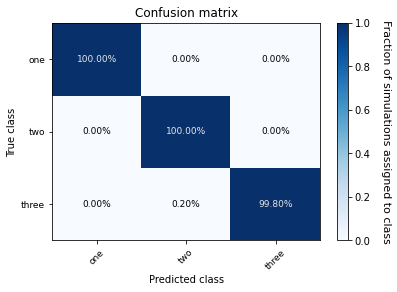

[[1000    0    0]
 [   0 1000    0]
 [   0    1  999]]


/tmp/ipykernel_1594336/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


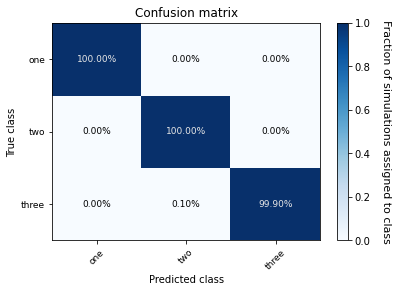

[[1000    0    0]
 [   0 1000    0]
 [   0    1  999]]


/tmp/ipykernel_1594336/1503990667.py:16: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)


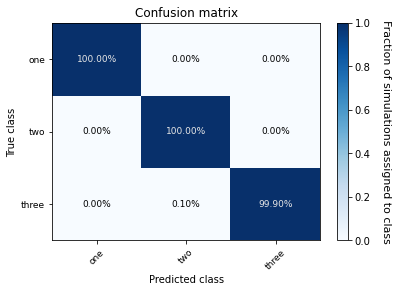

In [14]:
# Now we will plot the confusion matrices for each trained model
#first get the predictions
pred = model1.predict([traits_BM.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions for the next dataset
pred = model2.predict([traits_OU.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

# get the predictions for the next dataset
pred = model3.predict([traits_disc.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

# Print the confusion matrix
print (confusion_matrix(ytest, pred_cat))
#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()